# OT-guided regression

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

from utils import plot_maxproj, pixel_dist_3d

In [3]:
np.random.seed(1993)

## Create synthetic data

In [4]:
# Image size
img_shape = (50, 25, 5)
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

# Grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

### Source frame

In [5]:
cov = 5 * np.eye(3)
mu_1 = np.array([20, 10, 3])
mu_2 = np.array([10, 15, 3])

cell_1 = multivariate_normal.pdf(grid, mu_1, cov).reshape(img_shape)
cell_2 = multivariate_normal.pdf(grid, mu_2, cov).reshape(img_shape)

frame_1 = cell_1  + cell_2
frame_1[frame_1 < 1e-4] = 0

### Target frame

In [6]:
# Affine transformation to apply to source image
#theta = np.pi / 16
#beta = np.array([
#    [np.cos(theta), -np.sin(theta), 0], 
#    [np.sin(theta),  np.cos(theta), 0],
#    [0,              0,             1]
#])
beta = np.eye(3, 3)
alpha = np.array([10, 5, 0])
#alpha = np.array([0, 0, 0])

# Transform source frame into target frame (requires inverse transform)
inv_beta = np.linalg.inv(beta)
inv_alpha = -inv_beta @ alpha
frame_2 = affine_transform(frame_1, inv_beta, inv_alpha)

### Add floor values and noise

In [7]:
# Parameters
floor_val = 1e-7
noise_level = 0

# Noise is absolute value of Gaussian
noise_1 = np.abs(np.random.randn(*img_shape)) * noise_level
noise_2 = np.abs(np.random.randn(*img_shape)) * noise_level

frame_1 = frame_1 + floor_val + noise_1
frame_2 = frame_2 + floor_val + noise_2

frame shape: (50, 25, 5)
num. pixels: 6250


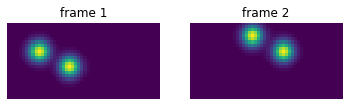

In [8]:
plt.subplot(121)
plot_maxproj(frame_1)
plt.title('frame 1')
plt.axis('off');

plt.subplot(122)
plot_maxproj(frame_2)
plt.title('frame 2')
plt.axis('off');

print(f'frame shape: {img_shape}')
print(f'num. pixels: {n_pixels}')

## Compare OT-based regression methods for recovering tranformation between frames

### Compute optimal transport plan between frames

In [9]:
# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Entropic regularization parameter
reg = 1e-3

In [10]:
# Compute transport plan
P = ot.sinkhorn(frame_1.flatten(), frame_2.flatten(), M, reg, verbose=False)

### Compute values used for all regression methods

In [11]:
# Compute pushforward
Q = P / frame_1.reshape(-1, 1)

# Matrix containing pixel coordinates
X = grid.reshape(-1, 3)

# Multiply grid points by pushforward matrix to get 'transformed' points
Y = Q @ X

In [12]:
def print_regression_report(alpha_est, beta_est, verbose=False):
    
    alpha_mse = np.sum((alpha_est - alpha) ** 2) / 3
    beta_mse = np.sum((beta_est - beta) ** 2) / 9
    
    # Reconstruct frame 2 using estimated transformation
    inv_beta_est = np.linalg.inv(beta_est)
    inv_alpha_est = -inv_beta_est @ alpha_est
    img_recon = affine_transform(frame_1, inv_beta_est, inv_alpha_est)
    
    img_se = np.sum((img_recon - frame_2) ** 2)

    print(f'MSE (alpha): {alpha_mse:7.4f}')
    print(f'MSE (beta):  {beta_mse:7.4f}')
    print(f'SE  (img):   {img_se:7.4f}')

    if verbose:
        
        print('alpha (est):')
        print(alpha_est)

        print('beta (est):')
        print(beta_est)
        
        plt.subplot(131)
        plot_maxproj(frame_1)
        plt.title('frame 1')
        
        plt.subplot(132)
        plot_maxproj(frame_2)
        plt.title('frame 2')
        
        plt.subplot(133)
        plot_maxproj(img_recon)
        plt.title('frame 2 (recon)')

### Method 1: Ordinary Least Squares (OLS) regression with no weights

MSE (alpha):  4.8737
MSE (beta):   0.0128
SE  (img):    0.0037
alpha (est):
[7.29548464 7.70128473 0.09809185]
beta (est):
[[ 0.85029686  0.02750062  0.01079123]
 [-0.03565315  0.71657513  0.02792305]
 [ 0.00335904  0.00661157  0.90439754]]


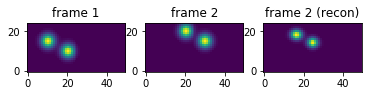

In [13]:
ols = LinearRegression(fit_intercept=True)
ols.fit(X, Y)

print_regression_report(ols.intercept_, ols.coef_, verbose=True)

### Method 2: Weights are pixel values from first frame

MSE (alpha):  4.2105
MSE (beta):   0.0062
SE  (img):    0.0011
alpha (est):
[8.84387741 8.36009782 0.06896151]
beta (est):
[[ 1.00624573e+00  8.84845214e-02 -6.39670723e-04]
 [-5.35591981e-02  7.89958036e-01  1.34360395e-03]
 [-6.75533381e-05 -5.05392054e-04  9.73420009e-01]]


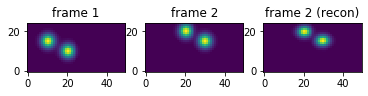

In [14]:
wls_1 = LinearRegression(fit_intercept=True)
wls_1.fit(X, Y, sample_weight=frame_1.flatten())

print_regression_report(wls_1.intercept_, wls_1.coef_, verbose=True)

### Method 3: Weights are inverse variance values

MSE (alpha): 38.4165
MSE (beta):   0.0012
SE  (img):    0.0055
alpha (est):
[0.43839794 0.11946073 0.074578  ]
beta (est):
[[ 9.99655171e-01 -1.38674112e-02 -4.53825083e-02]
 [ 1.92938710e-02  9.72874751e-01 -5.57446917e-02]
 [ 9.96444052e-04  4.53380463e-03  9.32788647e-01]]


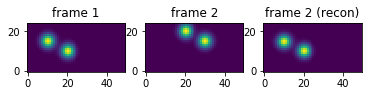

In [15]:
# Compute isotropic variances for each pixel
sq_dist = ot.dist(X, Y, metric='sqeuclidean')
var = np.sum(sq_dist * Q / 3, axis=1)

# Set weights to reciprocal of variance
weights = 1 / var

wls_2 = LinearRegression(fit_intercept=True)
wls_2.fit(X, Y, sample_weight=weights)

print_regression_report(wls_2.intercept_, wls_2.coef_, verbose=True)

### Method 4: Weights are values from P matrix

MSE (alpha):  4.2667
MSE (beta):   0.0062
SE  (img):    0.0011
alpha (est):
[8.77848333 8.36199926 0.07096308]
beta (est):
[[ 1.00868565e+00  9.11713171e-02 -1.26977069e-03]
 [-5.35103802e-02  7.89872804e-01  1.16703836e-03]
 [-1.32680075e-04 -6.02245604e-04  9.73498222e-01]]


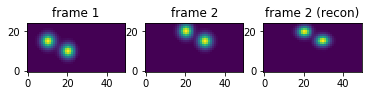

In [16]:
pts = grid.reshape(-1, 3)

threshold = 1e-7
x_idx, y_idx = np.nonzero(P > threshold)

pts_x = pts[x_idx]
pts_y = pts[y_idx]
weights = P[x_idx, y_idx]

wls_3 = LinearRegression(fit_intercept=True)
wls_3.fit(pts_x, pts_y, sample_weight=weights)

print_regression_report(wls_3.intercept_, wls_3.coef_, verbose=True)

### Compute pushforward of pixels

We want to see if part of the reason the above regressions aren't working is because of entropy in the OT plan.

In [17]:
def plot_pushforward(x, y, z):
    
    # Get pushforward for pixel
    lin_idx = np.ravel_multi_index((x, y, z), img_shape)
    pf = Q[lin_idx, :]
    pf_img = pf.reshape(img_shape)
    
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(131)
    plot_maxproj(frame_1)
    plt.plot(x, y, color='red', marker='*', markersize=10)
    plt.title('frame 1')
    
    plt.subplot(132)
    plot_maxproj(pf_img)
    plt.title('pushforward')
    
    plt.subplot(133)
    plot_maxproj(frame_2)
    plt.title('frame 2')

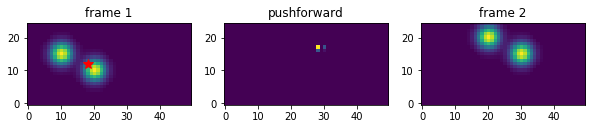

In [18]:
plot_pushforward(18, 12, 3)